# Prediction of the KS system

In this notebook, I will code some interesting functions to compare all models made to predict the KS system.

In [13]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [14]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [15]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [16]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [17]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [48]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        past=current_state[:,:,steps_to_predict:size_conv_time]
        current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
        current_state[:,:,0:(size_conv_time-steps_to_predict)]=past
        current_state[:,:,(size_conv_time-steps_to_predict):]=y


    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')
    
    return prediction_model_np,y_true_np, np.absolute(dif)

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [19]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [8]:
cd ../Callado/Documents/GitHub/Research-internship/Simulators/ks-simulator/dataset1_u3/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset1_u3


In [9]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


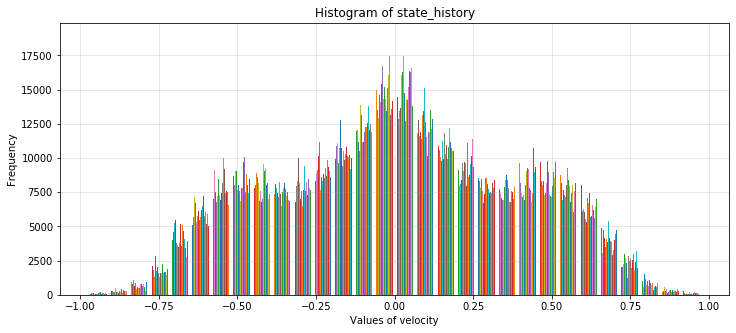

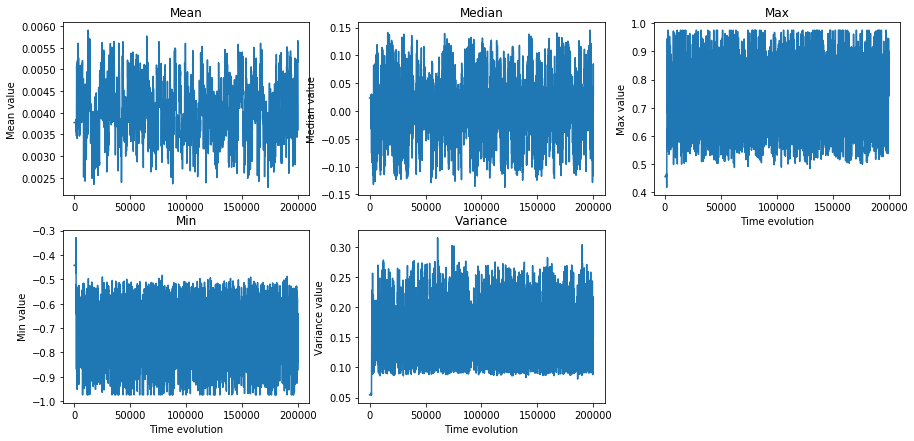

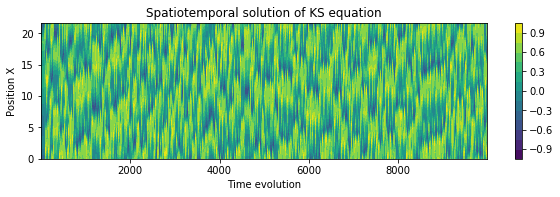

In [11]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=200000, width = 10, divwidth = 4)

In [20]:
#state_history_norm=state_history_norm[:100000,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(200001, 64)

In [25]:
cd ../Callado/Documents/GitHub/Research-internship/Simulators/ks-simulator/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


## Loading the models that we wanna compare

In [54]:
Number_of_Models = 2

total_prediction = 1000

positions = [200,3000,150000]

delta_all_model_sp200 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp3000 = np.zeros((Number_of_Models, total_prediction))
delta_all_model_sp150000 = np.zeros((Number_of_Models, total_prediction))

In [100]:
#TO LOAD THE MODEL. 

# First create objects of the good types 

size_conv_time=100
steps_to_predict=10

Lin = size_conv_time
in_ch_conv_1 = sample_points
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
hidden_1 = sample_points*5
out_lin = sample_points*steps_to_predict


model = th.nn.Sequential()
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()


# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("modelcv3_model1_u3")

# restore the model and optimizer states: 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']


# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("epoch:", epoch)
print("batch_size:", batch_size)
print("loss:", loss_fn)
    
# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

#plot some graphs
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 2, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)

C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "3.weight", "3.bias", "7.weight", "7.bias", "9.weight", "9.bias". 

Start_position= 200
The true solution:


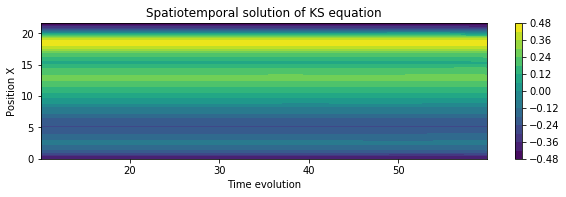

The model solution:


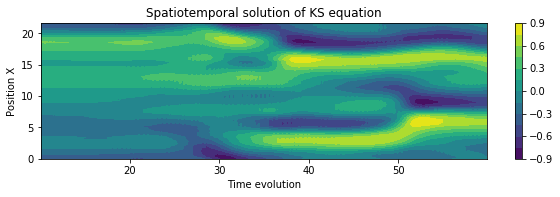

Start_position= 3000
The true solution:


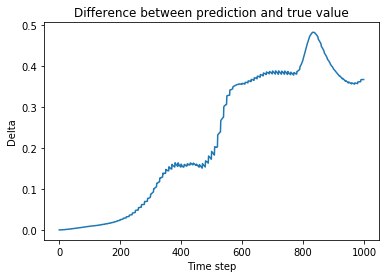

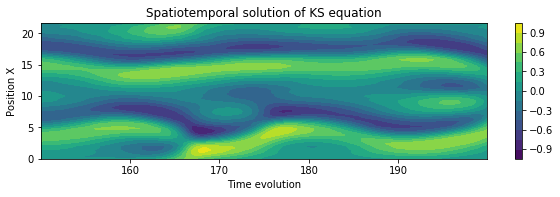

The model solution:


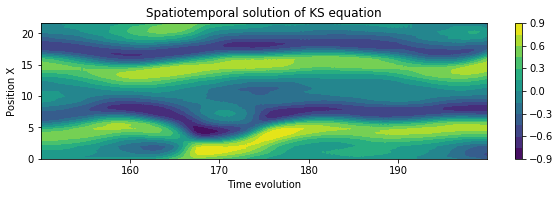

Start_position= 150000
The true solution:


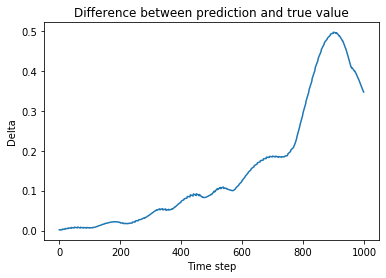

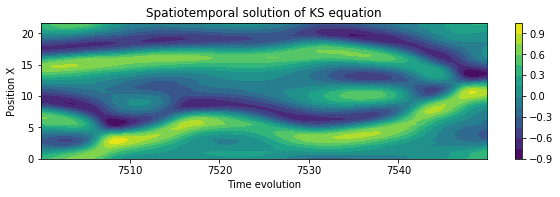

The model solution:


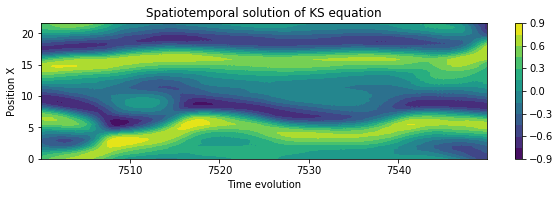

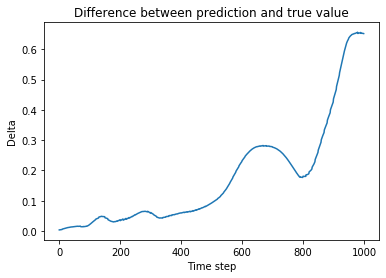

In [57]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp200[0,:] = dif

start_position=3000
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp3000[0,:] = dif

start_position=150000
N_step_simu=100
print('Start_position=', start_position)
pp,yy, dif = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
delta_all_model_sp150000[0,:] = dif

## Comparing the simulation for different start_position

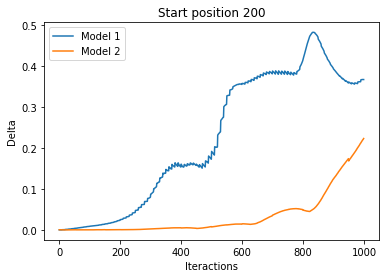

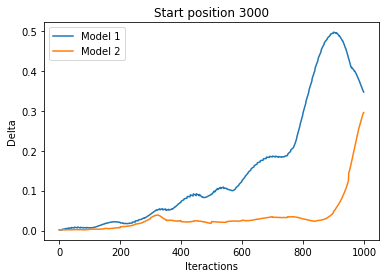

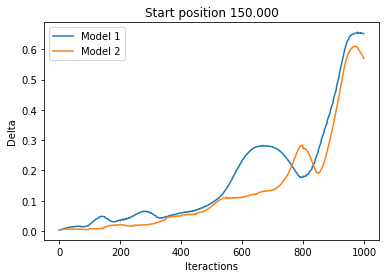

In [98]:
plt.plot(delta_all_model_sp200[0,:])
plt.plot(delta_all_model_sp200[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 200')
plt.show()

plt.plot(delta_all_model_sp3000[0,:])
plt.plot(delta_all_model_sp3000[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 3000')
plt.show()

plt.plot(delta_all_model_sp150000[0,:])
plt.plot(delta_all_model_sp150000[1,:])
plt.legend(['Model 1','Model 2'])
plt.ylabel('Delta')
plt.xlabel('Iteractions')
plt.title('Start position 150.000')
plt.show()